In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pandas.plotting import parallel_coordinates
from matplotlib.colors import ListedColormap
import matplotlib.ticker as plticker

In [181]:
# Set global plotting options

sns.set_style("darkgrid")
cp = sns.color_palette("Paired", 13)
cm = ListedColormap(cp)

plt.rcParams["figure.figsize"] = (12,6)

In [3]:
# Load and prepare data

basic = pd.read_csv("data/rerun/output/articles_metadata.csv", index_col="pmid")
funding = pd.read_csv("data/rerun/output/articles_funding_dummies.csv", index_col="pmid")
mesh = pd.read_csv("data/rerun/output/articles_mesh_term_dummies.csv", index_col="pmid")
news = pd.read_csv("data/rerun/output/articles_news_coverage.csv", index_col="pmid")

funding = funding.apply(lambda x: x==1)
mesh = mesh.apply(lambda x: x==1)
news[['news_mention', 'tier1','tier2','tier3','tier4']] = news[['news_mention', 'tier1','tier2','tier3','tier4']].apply(lambda x: x==1)

us_funding = funding.us_gov_funding == 1
most_f_cancers = mesh[us_funding].sum().sort_values(ascending=False)
mapping = {day: i for i, day in enumerate(most_f_cancers.keys())}

## Boxplot of mentions

In [170]:
df = news[['news_count']].merge(mesh, left_index=True, right_index=True)
df = df[us_funding]

In [171]:
def update_mentions(row):
    for col in mesh.columns:
        if row[col]:
            row[col] = row['news_count']
        else:
            row[col] = None
    return row
df = df.apply(update_mentions, axis=1)[most_f_cancers.keys()]
df = df.replace(0, np.nan)
ave_mentions = df.mean()

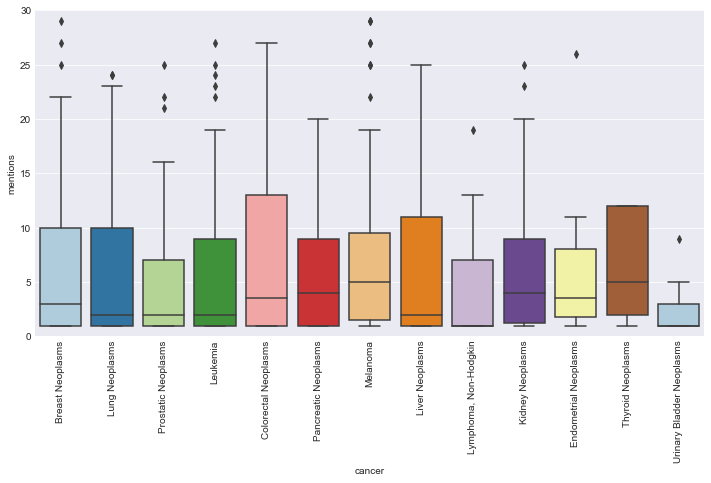

In [182]:
pdf = df.melt(value_name="mentions", var_name="cancer").dropna()

sns.boxplot(x="cancer", y="mentions", data=pdf, palette=cp)
plt.ylim(0,30);
plt.xticks(rotation=90);

## Plot - Rank Parallel Coordinates

How do the different cancers' ranks compare across:

- number of funded articles
- estimated new cases
- estimated deaths
- estimated funding

Set `add_news_mentions = True` to add the ranks by average news mentions

In [154]:
add_news_mentions = True
plot_legend = False

In [155]:
est_new = [255190, 222500, 135430, 62130, 161360, 53670, 40710, 87110, 72240, 63990, 61380, 56870, 79030]
est_death = [41070, 155870, 50260, 24500, 26730, 43090, 28920, 9730, 20140, 14400, 10920, 2010, 16870]
est_fund = [543.7,256.2,209.3,246.9,228.9,125.3,70.3,132.8,122.4,None,None,None,None]

df = mesh[us_funding]
plot_df = pd.DataFrame({'Articles':most_f_cancers.tolist(),
                        'Est. new cases': est_new,
                        'Est. deaths': est_death,
                        'Est. funding': est_fund,
                        'Ave. news mentions': ave_mentions.tolist()}, index=most_f_cancers.keys())

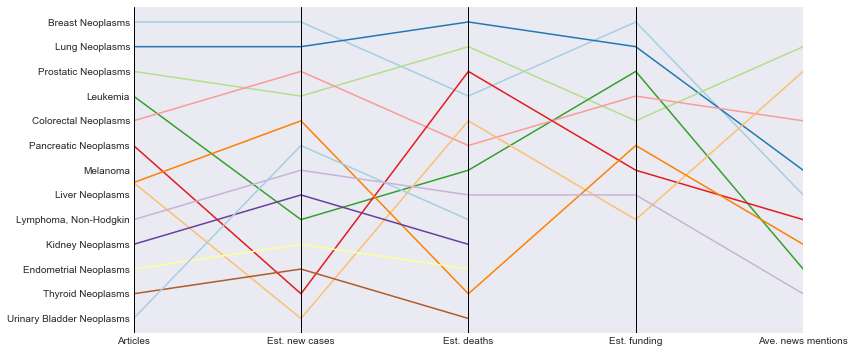

In [185]:
if add_news_mentions:
    plotcols = ['Articles', 'Est. new cases', 'Est. deaths', 'Est. funding', 'Ave. news mentions']
else:
    plotcols = ['Articles', 'Est. new cases', 'Est. deaths', 'Est. funding']
ranks = plot_df[plotcols].rank(ascending=False).reset_index()
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals

parallel_coordinates(ranks, 'index', colormap=cm)

plt.yticks(range(1,14))

ax = plt.gca()
ax.invert_yaxis()
if plot_legend:
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
else:
    def mjrFormatter(x, pos):
        return "{}".format(most_f_cancers.keys().tolist()[pos])
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))
    ax.legend_.remove()

## Correlation plots for the previous data

- funded articles
- estimated new cases
- estimated deaths
- estimated funding
- average news mentions

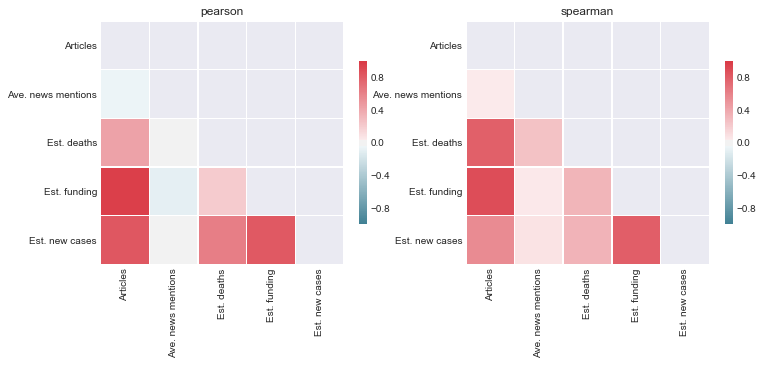

In [184]:
f, axes = plt.subplots(1, 2)
methods = ["pearson", "spearman"]
for ax, method in zip(axes, methods):
    corr = plot_df.corr(method=method)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    ax.set_title(method)

# Plot - Stacked bar plot of stages of cancer